In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

In [60]:
def single_simulation(P, delta=0.95, alpha=0.3, N=4, G=100,
                       ci=0.15, ce=0.1, ki=0,ke=0.05, be=0.005, bi=100, beta=1.410**-4, WTP=1):
    period_exited = []
    p2s = []
    p1s = []
    profit1s = []
    profit2s = []
    all_bes = []
    opp_p = [0,1/6,2/6,3/6,4/6,5/6,1,1.1]
    # def max_column(Q, state):
    #     own_price, opp_price, exit_state, period = state

    #     if own_price in Q and opp_price in Q[own_price] and exit_state in Q[own_price][opp_price]:
    #         return max(Q[own_price][opp_price][exit_state].values())


    def pi(p1,p2,c,k, WTP):
        if p1 <= WTP and p1<p2:
            return p1 - c - k
        elif p1 == p2 and p1 <= WTP:
            return (p1 - c)/2 - k
        else:
            return -k

    def Q_update(Q, own_price, opp_price, exit_state, period, new_state, profit, opp_P=opp_p):
        new_own_price, _, _, _ = new_state  

        prev_q = Q[own_price][opp_price][exit_state][period-1]

        max_future_q = max(Q[new_own_price][x][exit_state][period] for x in opp_P)


        Q[own_price][opp_price][exit_state][period-1] = (
            (1 - alpha) * prev_q + alpha * (profit + delta * max_future_q)
        )

        return Q


    def epsilon(g,beta=beta):
        return np.exp(-beta*g)

    def exploit_explore(Q, t, state, P):
        _, opp_price, exit_state, period = state

        if np.random.rand() < epsilon(t):
            return np.random.choice(P)

        q_values = {a: Q[a][opp_price][exit_state][period] for a in P if a in Q}

        max_q = max(q_values.values())
        best_actions = [a for a in q_values if q_values[a] == max_q]

        return np.random.choice(best_actions)

    def create_Q_table(P=P, N=N, opp_P=opp_p):
        Q = {}
        for own_price in P:          
            Q[own_price] = {}
            for opp_price in opp_P:      
                Q[own_price][opp_price] = {}
                for exit_state in [0, 1]:   
                    Q[own_price][opp_price][exit_state] = {}
                    for period in range(N):  
                        Q[own_price][opp_price][exit_state][period] = 0  
        return Q
    Q1 = create_Q_table()
    Q2 = create_Q_table()


    def q_learning_simulationde(Q1, Q2, G=G, WTP=WTP, N=N):
        g = 0
        while g != G:
            p1 = [WTP]
            p2 = [WTP]
            bes = []
            profit1 = []
            profit2 = []
            p_exit = []
            t = 1
            b_e = be
            b_i = bi
            exit_state_i = 1
            exit_state_e = 1
            while t != N:
                    pi_i = pi(p1[t-1],p2[t-1],ci,ki,WTP)
                    pi_e = pi(p2[t-1],p1[t-1],ce,ke,WTP)
                    if t!=1:
                        b_i = b_i + pi_i
                        b_e = b_e + pi_e
                    if b_i < 0:
                        exit_state_i = 0
                    else:
                        exit_state_i = 1
                    bes.append(b_e)
                    if b_e <= 0:
                        exit_state_e = 0
                    else:
                        exit_state_e = 1
                    new_state_i = (p1[t-1], p2[t-1], 1, t)
                    new_state_e = (p2[t-1], p1[t-1], 1, t)


                    Q1 = Q_update(Q1, p1[t-1], p2[t-1], exit_state_i, t, new_state_i, pi_i)

                    if exit_state_e == 1:
                        Q2 = Q_update(Q2, p2[t-1], p1[t-1], exit_state_e, t, new_state_e, pi_e)


                    state_i = (p1[t-1], p2[t-1], 1, t)
                    state_e = (p2[t-1], p1[t-1], 1, t)
                    if exit_state_i == 0:
                        p1_new = 1.1
                    else:
                        p1_new=exploit_explore(Q1,t,state_i,P)
                    p1.append(p1_new)

                    if exit_state_e == 0:
                        p2_new = 1.1
                        p_exit.append(t) 
                    else:
                        p2_new=exploit_explore(Q2,t,state_e,P)
                    p2.append(p2_new)



                    profit1.append(pi_i)
                    profit2.append(pi_e)

                    
                    t+=1
            p1s.append(p1)
            p2s.append(p2)
            all_bes.append(bes)
            profit1s.append(profit1)
            profit2s.append(profit2)
            period_exited.append(p_exit)
            g+=1

        return period_exited, p1s, p2s, profit1s, profit2s, all_bes, Q1, Q2

    period_exited = q_learning_simulationde(Q1, Q2)

    return period_exited



[0.005, 0.1883333333333333, 0.7049999999999998]
[1, 0.3333333333333333, 0.6666666666666666, 1.0]


TypeError: unhashable type: 'list'

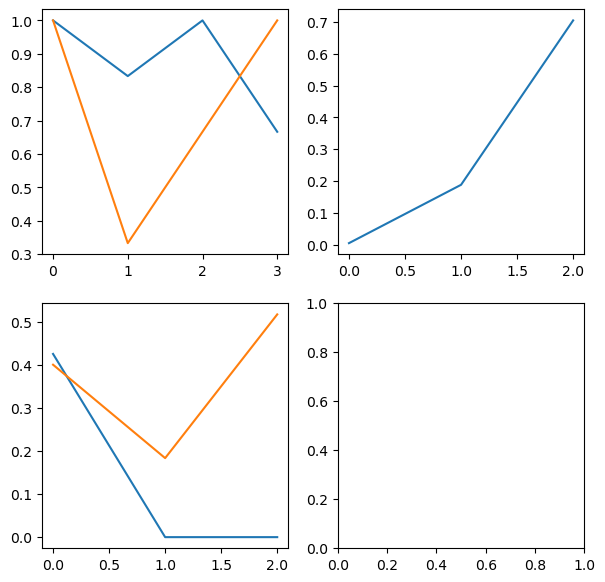

In [ ]:
np.random.seed(1284)
P = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6]
single_sim = ((single_simulation(P, G=100000)))
print(single_sim[5][-1])
print(single_sim[2][-1])
period_exited = single_sim[0]
prices_i = single_sim[1][-1]
prices_e = single_sim[2][-1]
profits_i = single_sim[3][-1]
profits_e = single_sim[4][-1]
bes = single_sim[5][-1]
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0][0].plot(prices_i, label="Incum")
ax[0][0].plot(prices_e, label="Entrant")
ax[1][0].plot(profits_i, label="Incum profit")
ax[1][0].plot(profits_e, label="Entrant profit")
ax[0][1].plot(bes, label="entrant budget")
ax[1][1].bar()
ax[1][1].set_title("Period exited")
ax[0][1].set_title("entrant budget")
ax[0][0].set_title("Prices")
ax[1][0].set_title("Profits")
ax[0][0].legend()
ax[1][0].legend()
plt.show()

In [41]:
Q1 = single_sim[6]
print(Q1[1.1][0][0][3])

0


In [43]:
P = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6]
N = 4
opp_P = P
opp_P.append(1.1)

print(Q1[1.1][0][0][3])
# Print Q-table
header = f"{'Own Price':<10}{'Opp Price':<10}{'Exit State':<12}{'Period':<8}{'Q-Value':<8}"
print(header)
print("=" * len(header))

for own_price in P:
    for opp_price in opp_P:
        for exit_state in [0, 1]:
            for period in range(N):
                print(f"{own_price:<10.2f}{opp_price:<10.2f}{exit_state:<12}{period:<8}{Q1[own_price][opp_price][exit_state][period]:<8}")


0
Own Price Opp Price Exit State  Period  Q-Value 
0.00      0.00      0           0       0       
0.00      0.00      0           1       0       
0.00      0.00      0           2       0       
0.00      0.00      0           3       0       
0.00      0.00      1           0       0       
0.00      0.00      1           1       -0.14624999999999988
0.00      0.00      1           2       -0.07499999999999996
0.00      0.00      1           3       0       
0.00      0.17      0           0       0       
0.00      0.17      0           1       0       
0.00      0.17      0           2       0       
0.00      0.17      0           3       0       
0.00      0.17      1           0       0       
0.00      0.17      1           1       -0.22124999999999984
0.00      0.17      1           2       -0.1499999999999999
0.00      0.17      1           3       0       
0.00      0.33      0           0       0       
0.00      0.33      0           1       0       
0.00      0.33      

In [11]:
print(3%1000 == 0)

False


1
0
